In [1]:
from __future__ import division, print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tupak

import emcee

plt.rcParams['figure.figsize'] = [18, 12]

15:51 tupak INFO    : Running tupak version: 0.2.1 - (CLEAN) 55629c6 2018-07-18 08:35:37 +1000


### The problem

We have a template $T(\phi)$ (will probably use a von Mises to start with, or even just a Gaussian but stick to narrow widths) and we assume that the profiles are only the rescaled template with uncorrelated white noise (ignore baseline and shifts for now):

$$ P(\phi) = A T(\phi+\phi_0)\frac{P}{P_t}+n(\phi) $$

Assume that the noise has some variance $\sigma^2$, fixed throughout an observation.

We want to measure the period from multiple subints:

$$ P_{total}(\phi) = n(\phi) + \sum_{i=0}^{i=nsub-1}A_i * T(\phi+\phi_0+2\pi i)\frac{P}{P_t} $$

In [2]:
real_period = 0.00575770575112002
P = 0.005
sigma = 1
Nbin_data = 1024
width = 0.00004 

In [3]:
# let's get the first 100 profiles:
data = np.load("1minute_r05.npy")
data_flat = data.flatten()
data_flat_short = data_flat[0:1024*10]
time = np.linspace(0, 10 * real_period, 1024*10)

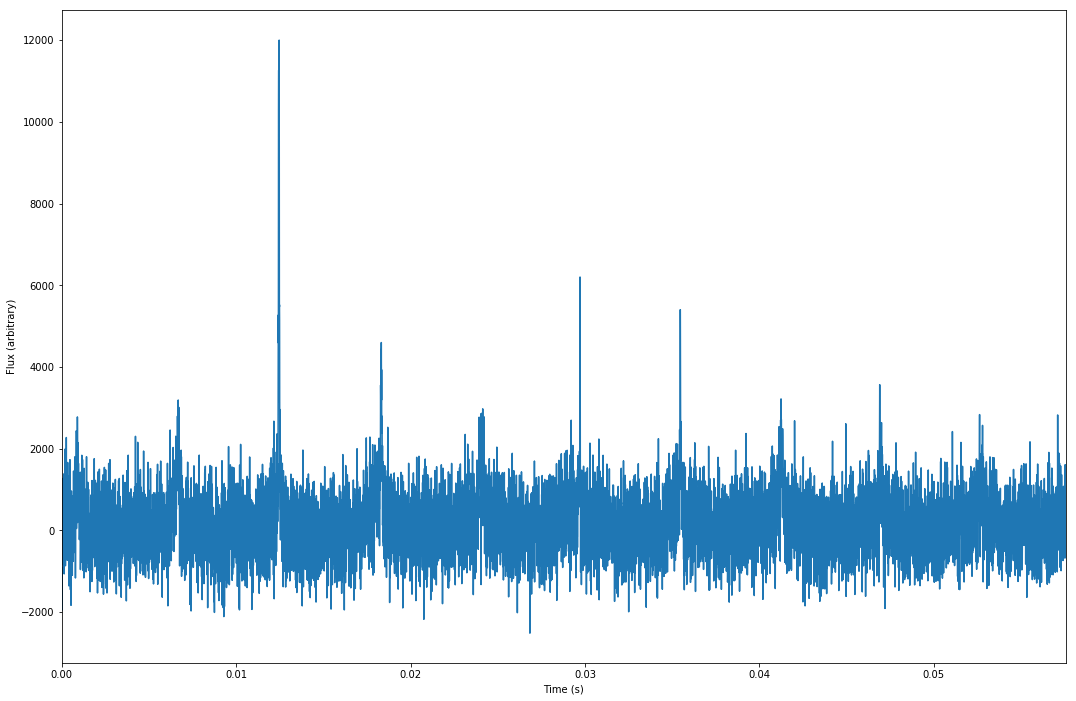

[0.00000000e+00 5.62330867e-06 1.12466173e-05 ... 5.75658109e-02
 5.75714342e-02 5.75770575e-02]


In [4]:
plt.plot(time, data_flat_short)
plt.xlabel('Time (s)')
plt.ylabel('Flux (arbitrary)')
plt.xlim([0, real_period*10])
plt.show()
print(time)

In [5]:
def pulsar_template(time, amplitude, width):
    '''
    Gaussian approximation of the pulsar pulse-profile
    '''
    
    mu = (time[0] + time[-1])/2
    
    return amplitude * np.exp(- ((time - mu)**2)/(2*width**2))

In [6]:
def break_into_subs(time, data, period):
    '''
    Break up the data into subsets with lengths equal to the pulse period being looked at
    '''
    num_breaks = int(len(time)/(time[-1]/period))
    
    shape=(time.size - num_breaks + 1, num_breaks)
    strides=(time.itemsize, time.itemsize)
    time_sub = np.lib.stride_tricks.as_strided(time, shape=shape, strides=strides)
    data_sub = np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)
    
    return time_sub, data_sub

In [7]:
def ln_prior(theta):
    '''
    prior on the parameters (uniform)
    '''
    amplitude, width, period = theta
    
    if amplitude < min_amp or amplitude > max_amp and  width < min_width or width > max_width and period < min_per or period > max_per:
        return -np.inf
    
    else:
        return 0

In [ ]:
class PulsarLikehood(tupak.likelihood.Likelihood):
    def __init__(self, time, data):
        #tupak.likelihood.Likelihood.__init__()
        self.time = time
        self.data = data
        self.parameters = dict(amplitude=None, width=None, period=None)

    def log_likelihood(self):
        amplitude = self.parameters['amplitude']
        width = self.parameters['width']
        period = self.parameters['period']
        
        time_subs, data_subs = break_into_subs(self.time, self.data, period)
        sub_likelihoods = []

        for i  in range(0,len(time_subs[:,0])):

            profile_model = pulsar_template(time_subs[i,:], amplitude, width) 
            residuals = data_subs[i,:] - profile_model
            likelihood = -0.5 * np.sum(residuals**2 / (2*sigma**2) + np.log(np.sqrt(2*np.pi*sigma**2)))
            sub_likelihoods.append(likelihood)

        return np.sum(sub_likelihoods) 
    
likelihood = PulsarLikehood(time, data_flat_short)
priors = dict()
priors['amplitude'] = tupak.prior.Uniform(min_amp, max_amp, 'amplitude')
priors['width'] = tupak.prior.Uniform(min_width, max_width, 'width')
priors['period'] = tupak.prior.Uniform(min_per, max_per, 'period')

result = tupak.sampler.run_sampler(likelihood=likelihood, priors=priors, sampler='emcee', nsteps=500, nburn=100)
result.plot_corner()

15:51 tupak INFO    : Search parameters:
15:51 tupak INFO    :   amplitude = Uniform(name='amplitude', latex_label='amplitude', minimum=100, maximum=10000)
15:51 tupak INFO    :   width = Uniform(name='width', latex_label='width', minimum=0.001, maximum=1)
15:51 tupak INFO    :   period = Uniform(name='period', latex_label='period', minimum=0.0001, maximum=0.057577057511200194)
15:51 tupak INFO    : Single likelihood evaluation took 2.295e-01 s
15:51 tupak INFO    : Using sampler Emcee with kwargs {'nsteps': 500, 'nburn': 100}
 14%|█▍        | 71/500 [19:06<1:55:24, 16.14s/it]

In [8]:
def ln_likelihood(theta, time, data):
    '''
    log of the likelihood function
    '''
    amplitude, width, period = theta
    time_subs, data_subs = break_into_subs(time, data, period)
    sub_likelihoods = []
    
    for i  in range(0,len(time_subs[:,0])):
    
        profile_model = pulsar_template(time_subs[i,:], amplitude, width) 
        residuals = data_subs[i,:] - profile_model
        likelihood = -0.5 * np.sum(residuals**2 / (2*sigma**2) + np.log(np.sqrt(2*np.pi*sigma**2)))
        sub_likelihoods.append(likelihood)
        
    return np.sum(sub_likelihoods) 

In [12]:
def ln_posterior(theta, time, data):
    '''
    log of the posterior
    '''
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_l = ln_likelihood(theta, time, data)
    return ln_p + ln_l

In [8]:
sigma = 1000
# Run it for a few hundred steps
nwalkers = 100
nsteps = 1000
nburn = 500
ndim = 3

min_amp = 100; max_amp = 10000
min_width = 1e-3; max_width = 1
min_per = 0.0001; max_per = time[-1]

pos = np.ones((nwalkers, ndim))
pos[:,0] *= [np.random.uniform(min_amp, max_amp) for i in range(nwalkers)]
pos[:,1] *= [np.random.uniform(min_width, max_width) for i in range(nwalkers)]
pos[:,2] *= [np.random.uniform(min_per, max_per) for i in range(nwalkers)]

In [14]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(time, data_flat_short))
out = sampler.run_mcmc(pos, nsteps)

-66831522.37900812
-408268283.7947631
-143481165.22743958
-516546031.26649094
-727791795.1649125
-304923693.63338995
-473078224.6130434
-231032806.80893514
-24403390.95305944
-154739001.84917036
-90507414.02106194
-27911606.203995496
-399650880.8248072
-223590895.34072343
-27937229.551224664
-154925656.38287997
-133348874.79291409
-372220674.94447887
-131307470.46287395
-90083844.12267733
-350910745.0728219
-73848519.58187477
-89464869.37599348
-427955125.4572302
-530384222.9793055
-253020425.6377317
-126172504.61117406
-297205426.6373887
-458808605.7533945
-137106598.32423797
-360238279.67573255
-463603742.7061566
-617350113.4890156
-575944885.5648131
-276875470.66896105
-43502314.54556227
-16972996.583374932
-204890356.97925758
-40931222.73785524
-609555029.1622573
-82290880.77266137
-382995514.91530234
-271663750.33821625
-332740720.6923156
-421175279.35162425
-198693236.5177901
-113758556.74256998
-111546178.87041703
-156494002.71220863
-393404121.0880994
-143718598.12783104
-11610

Traceback (most recent call last):
  File "/Users/MarcusLower/.local/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-12-ef704983b124>", line 8, in ln_posterior
    ln_l = ln_likelihood(theta, time, data)
  File "<ipython-input-8-2f73b4ea08ee>", line 11, in ln_likelihood
    profile_model = pulsar_template(time_subs[i,:], amplitude, width)
  File "<ipython-input-5-c190c8e4e776>", line 8, in pulsar_template
    return amplitude * np.exp(- ((time - mu)**2)/(2*width**2))
KeyboardInterrupt


KeyboardInterrupt: 

In [8]:
period = 0.005
t_sub, d_sub = break_into_subs(time, data_flat_short, period)
np.shape(t_sub[0,:])

(889,)

In [30]:
temp = pulsar_template(t_sub[-1,:], 20000, 0.0001)

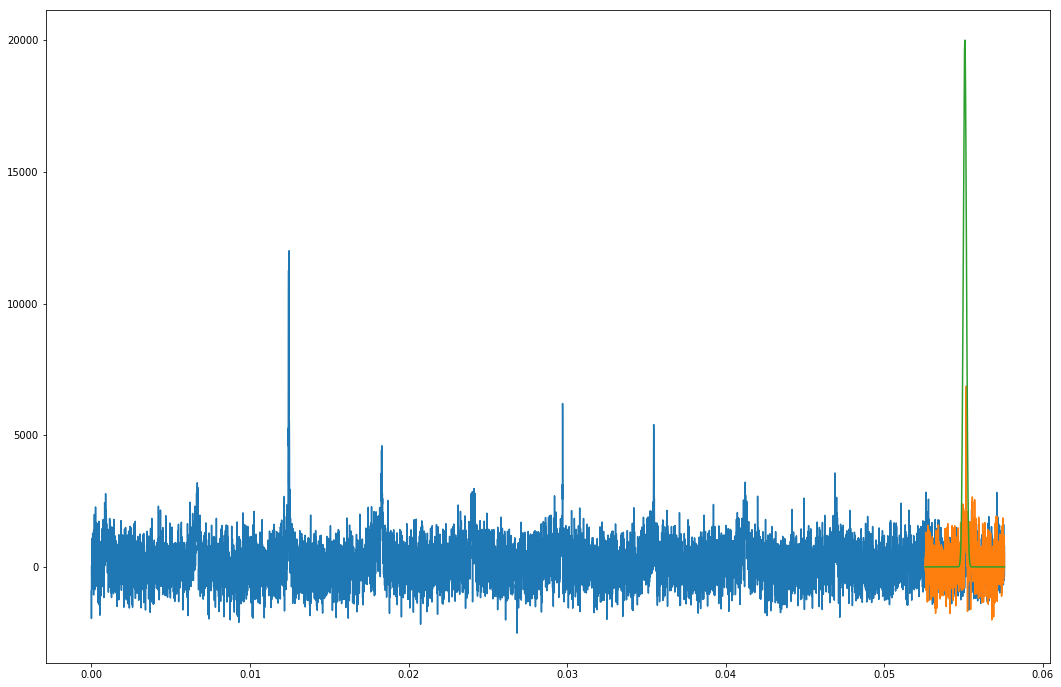

In [32]:
plt.plot(time, data_flat_short)
plt.plot(t_sub[-1,:], d_sub[-1,:])
plt.plot(t_sub[-1,:], temp)
plt.show()

In [30]:
def chunks(array, num_chunks):
    num_chunks = max(1, num_chunks)
    return (array[i:i+num_chunks] for i in range(0, len(array), num_chunks))